# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels
from lib.shared.segment_cellpose import estimate_diameters, segment_cellpose
from lib.shared.segment_microsam import segment_microsam
from lib.shared.segment_stardist import segment_stardist
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.phenotype.identify_vacuoles import segment_vacuoles, create_vacuole_boundary_visualization
from lib.phenotype.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)
from lib.phenotype.extract_phenotype_vacuoles import extract_phenotype_vacuoles

2025-04-28 19:56:19.305099: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [3]:
# parameters for testing
TEST_PLATE = 1
TEST_WELL = "A3"
TEST_TILE = 1
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["DAPI", "ConA", "Mitotracker", "Stat6", "DAPI2", "NHS_ester", "DAPI3", "Tubulin", "cMYC", "WGA", "CDPK1"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_yellow", "pure_blue", "pure_green", "pure_blue", "pure_green", "pure_red", "pure_yellow", "pure_magenta"]

# parameters for feature extraction
FOCI_CHANNEL = None

Loading test image...
Applying illumination correction...
Example corrected image:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


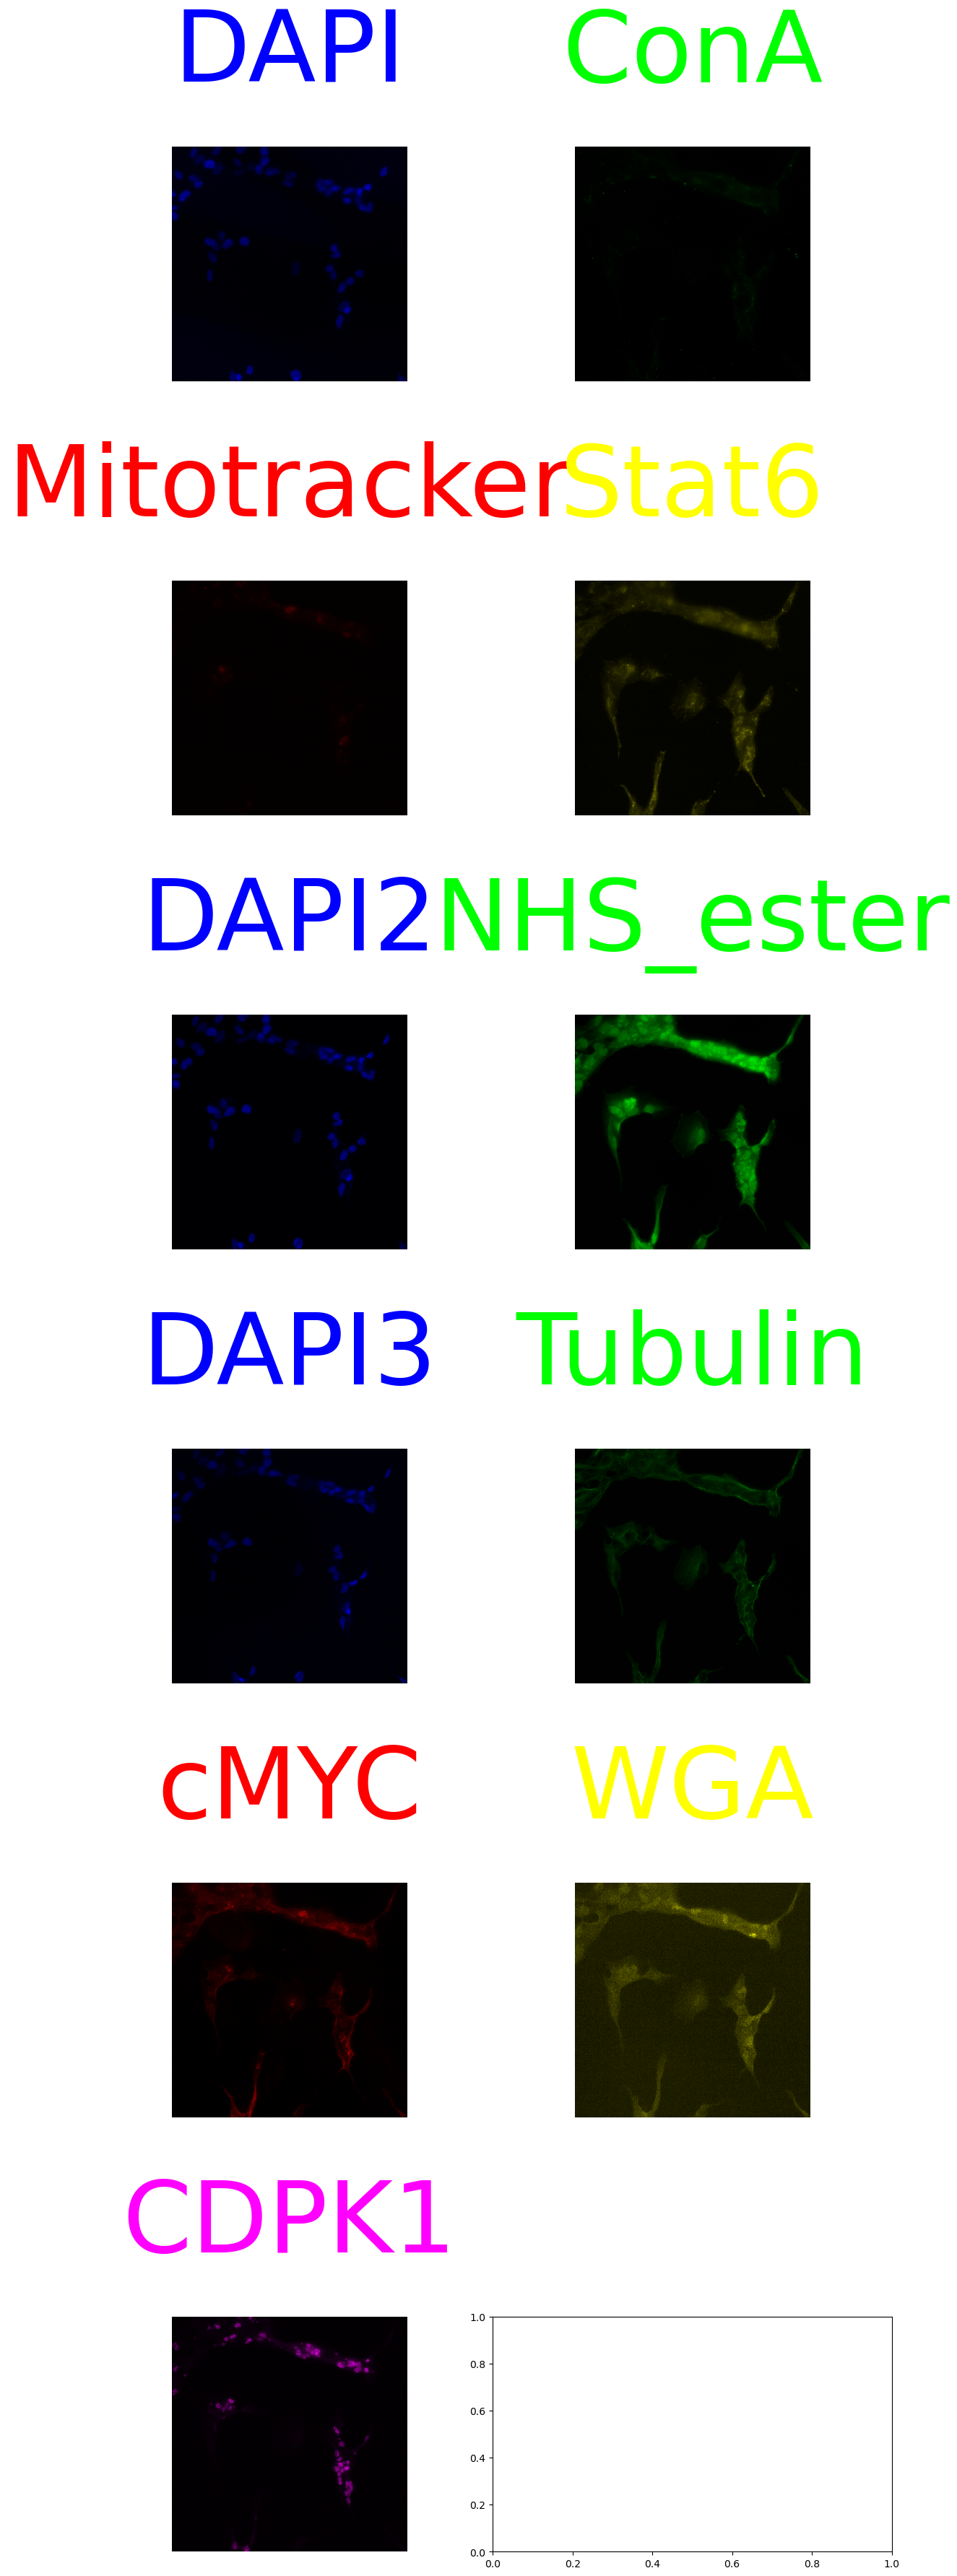

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Index of the channel that other channels will be aligned to.
- `SOURCE`: Index of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.

In [5]:
# Set alignment parameters 
ALIGN = True

# Define single alignment configuration for all wells with multiple steps
ALIGNMENTS = {
    1: {
        "steps": [
            # First alignment step
            {
                "target": 0,  # DAPI from first round
                "source": 4,  # DAPI2 (assuming this is position 5)
                "riders": [5],  # Other channels in second round
                "remove_channel": "source"  # Remove DAPI2 after alignment
            },
            # Third alignment step
            {
                "target": 0,  # DAPI from first round
                "source": 5,  # DAPI3 (assuming this is position 10)
                "riders": [6, 7, 8, 9],  # Other channels in third round
                "remove_channel": "source"  # Remove DAPI3 after alignment
            }
        ]
    }
}

In [6]:
if ALIGN:
    print("Aligning channels...")
    # Get alignment configuration for the current plate
    plate_config = ALIGNMENTS.get(TEST_PLATE)
    
    if plate_config:
        # Start with the corrected image
        aligned_image = corrected_image
        
        # Check if this is a multi-step alignment (has "steps" key)
        if "steps" in plate_config:
            print(f"Performing multi-step alignment for plate {TEST_PLATE}...")
            
            # Apply each alignment step in sequence
            for step_num, step in enumerate(plate_config["steps"], 1):
                print(f"  Step {step_num}: Aligning {step['target']} (target) with {step['source']} (source)")
                aligned_image = align_phenotype_channels(
                    aligned_image,
                    target=step["target"],
                    source=step["source"],
                    riders=step["riders"],
                    remove_channel=step["remove_channel"],
                )
                CHANNEL_NAMES.pop(step["source"])
                CHANNEL_CMAPS.pop(step["source"])
        else:
            # Single-step alignment
            print(f"Performing single-step alignment for plate {TEST_PLATE}...")
            aligned_image = align_phenotype_channels(
                corrected_image,
                target=plate_config["target"],
                source=plate_config["source"],
                riders=plate_config["riders"],
                remove_channel=plate_config["remove_channel"],
            )
    else:
        # No configuration found for this plate
        print(f"Warning: No alignment configuration found for plate {TEST_PLATE}")
        aligned_image = corrected_image
else:
    aligned_image = corrected_image

Aligning channels...
Performing multi-step alignment for plate 1...
  Step 1: Aligning 0 (target) with 4 (source)


  Step 2: Aligning 0 (target) with 5 (source)


In [7]:
CHANNEL_NAMES, CHANNEL_CMAPS

(['DAPI',
  'ConA',
  'Mitotracker',
  'Stat6',
  'NHS_ester',
  'Tubulin',
  'cMYC',
  'WGA',
  'CDPK1'],
 ['pure_blue',
  'pure_green',
  'pure_red',
  'pure_yellow',
  'pure_green',
  'pure_green',
  'pure_red',
  'pure_yellow',
  'pure_magenta'])

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Common Parameters
- `CYTO_CHANNEL`: Channel to use for cell detection (typically "PHALLOIDIN")
- `GPU`: Set to True to use GPU acceleration (if available)
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing)

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".
- `POINTS_PER_SIDE`: Number of points to sample along each side of the image. Default is 32.
- `POINTS_PER_BATCH`: Number of points to process in one batch. Default is 16.
- `STABILITY_SCORE_THRESH`: Threshold for stability score. Default is 0.95.
- `PRED_IOU_THRESH`: Threshold for predicted IoU. Default is 0.88.

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `PROB_THRESH`: Probability threshold for segmentation. Default is 0.479071.
- `NMS_THRESH`: Non-maximum suppression threshold. Default is 0.3.

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [ ]:
# Common parameters
CYTO_CHANNEL = "ConA"
GPU = False
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)
SEGMENT_CELLS = False

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    FLOW_THRESHOLD = 0.4
    CELLPROB_THRESHOLD = 0

    # print("Estimating optimal cell and nuclei diameters...")
    # NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
    #     corrected_image,
    #     dapi_index=DAPI_INDEX,
    #     cyto_index=CYTO_INDEX,
    #     cyto_model=CELLPOSE_MODEL,
    # )

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"
    POINTS_PER_SIDE = 32
    POINTS_PER_BATCH = 16
    STABILITY_SCORE_THRESH = 0.95
    PRED_IOU_THRESH = 0.88

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    PROB_THRESH = 0.479071
    NMS_THRESH = 0.3

In [9]:
# Manually set cell diameter to 300
NUCLEI_DIAMETER = 100
CELL_DIAMETER = 300

Segmenting image with cellpose...


dtype.py (576): Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [3, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 37.40 sec
INFO:cellpose.models:channels set to [2, 3]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 119.22 sec
found 57 nuclei before removing ed

removing edges


found 47 nuclei before reconciling
found 28 cells before reconciling


reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 0 nuclei: 1
Cells with 1 nuclei: 23
Cells with 2 nuclei: 4
--------------------------



found 27 nuclei/cells after reconciling


Number of nuclei segmented: 27
Number of cells segmented: 27
Example microplots for DAPI channel and nuclei segmentation:


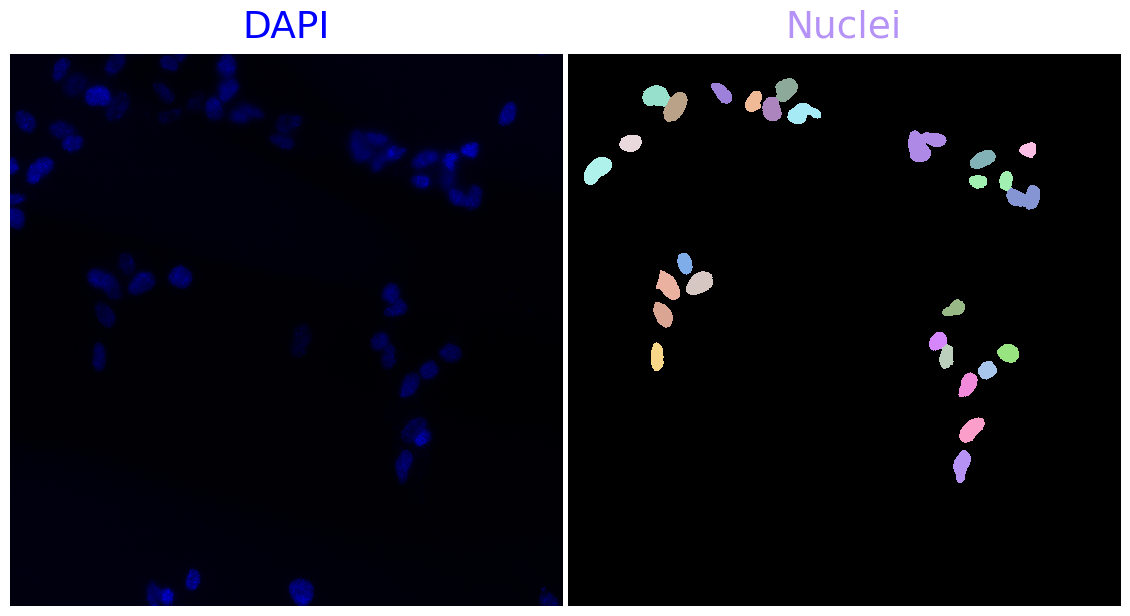

Example microplots for merged channels and cells segmentation:


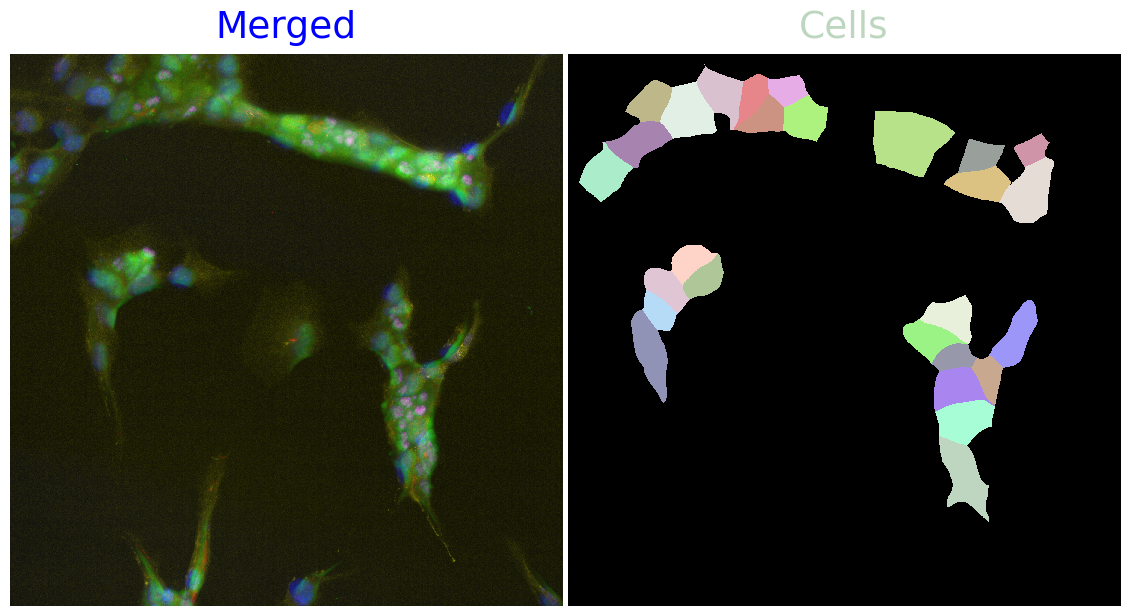

Example microplot for phenotype data annotated with segmentation:


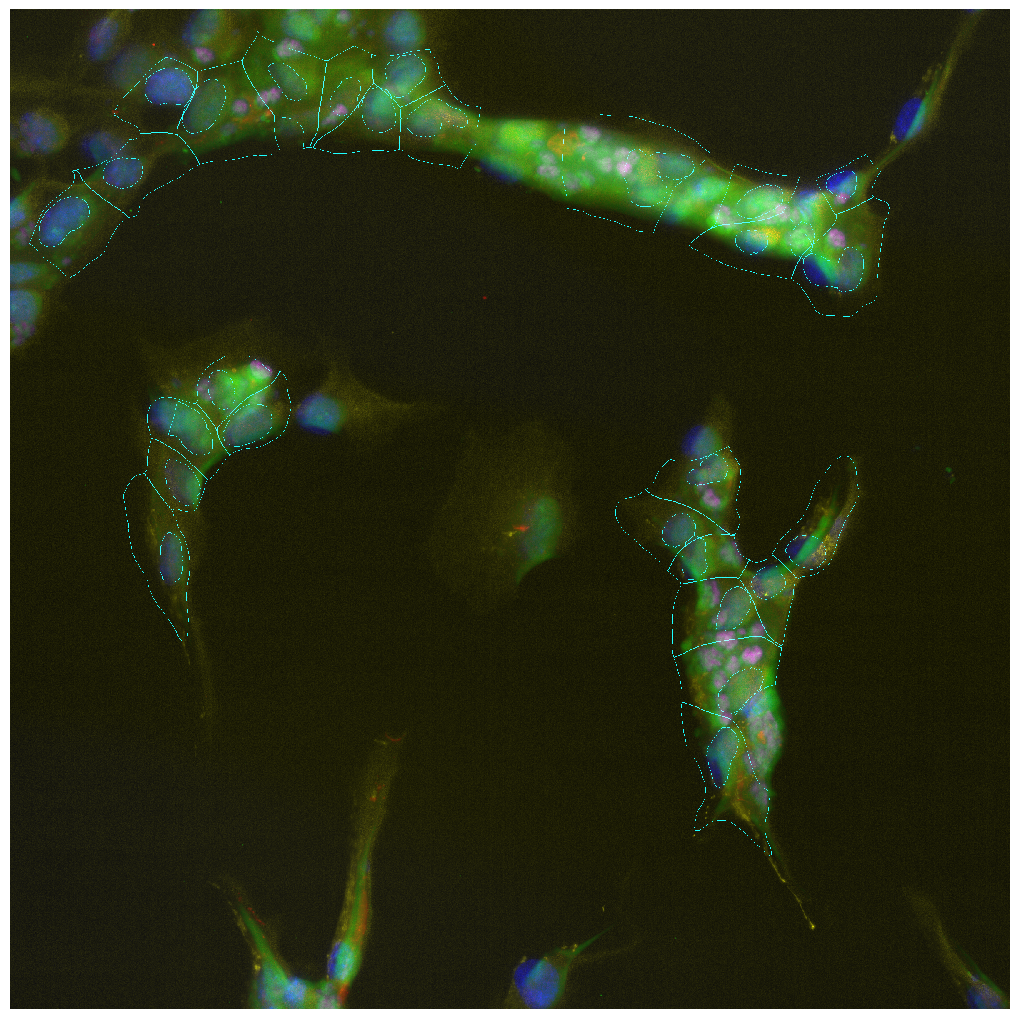

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 27


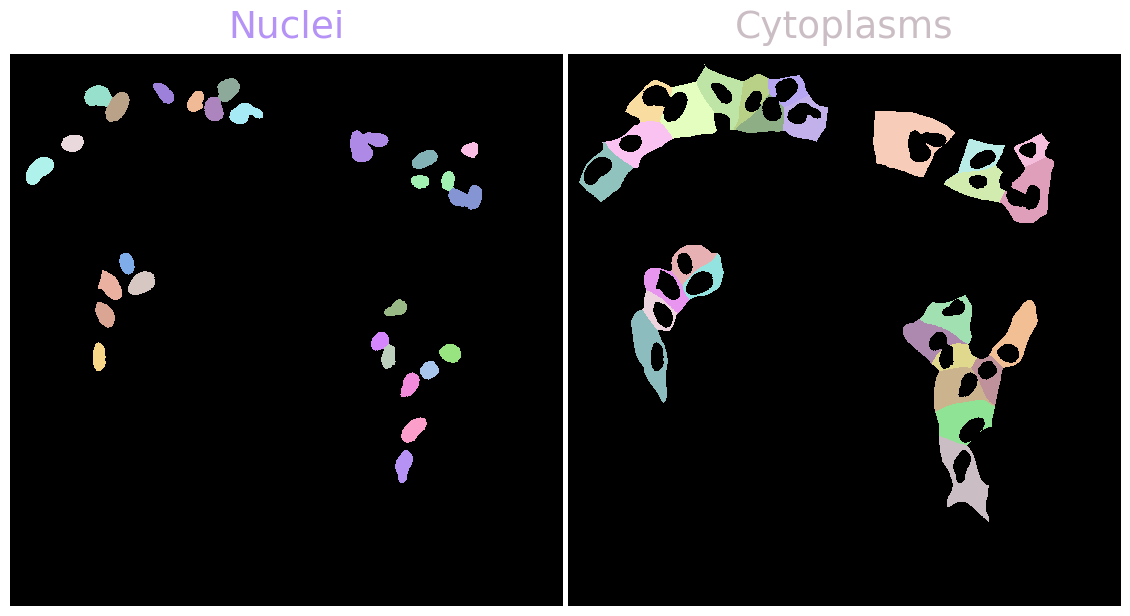

In [ ]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    nuclei = segment_cellpose(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            flow_threshold=FLOW_THRESHOLD,
            cellprob_threshold=CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "microsam":
    nuclei = segment_microsam(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        microsam_kwargs=dict(
            points_per_side=POINTS_PER_SIDE,
            points_per_batch=POINTS_PER_BATCH,
            stability_score_thresh=STABILITY_SCORE_THRESH,
            pred_iou_thresh=PRED_IOU_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "stardist":
    nuclei = segment_stardist(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            prob_thresh=PROB_THRESH,
            nms_thresh=NMS_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

cells = np.zeros_like(nuclei)

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS,
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

In [11]:
# Extract minimal phenotype data
phenotype_minimal = extract_phenotype_minimal(nuclei, nuclei, WILDCARDS)

## <font color='red'>SET PARAMETERS</font>

### Vacuole detection (optional)

- `VACUOLE_DETECTION`: Whether to perform vacuole detection.
- `VACUOLE_CHANNEL`: Name of the channel used for vacuole detection (typically CDPK1).

In [12]:
# Set vacuole parameters
VACUOLE_DETECTION = True
VACUOLE_CHANNEL = "CDPK1"
VACUOLE_MIN_SIZE = 20         
VACUOLE_MAX_SIZE = 5000

# Derive vacuole channel index from CHANNEL_NAMES
if VACUOLE_DETECTION:
    VACUOLE_CHANNEL_INDEX = CHANNEL_NAMES.index(VACUOLE_CHANNEL)

In [13]:
VACUOLE_CHANNEL_INDEX

8

Performing vacuole segmentation with CDPK1...


Kept 11 out of 51 detected vacuoles (21.6%)
Discarded 40 vacuoles that didn't sufficiently overlap with cells
Updated cytoplasm masks by removing 11 vacuole regions
Found vacuoles in 8 out of 27 cells
Average vacuoles per cell with vacuoles: 1.38
Average vacuole area ratio: 0.0255
Total nuclei detected within vacuoles: 93
Number of multinucleated vacuoles: 10
Example microplots for vacuole channel and vacuole segmentation:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


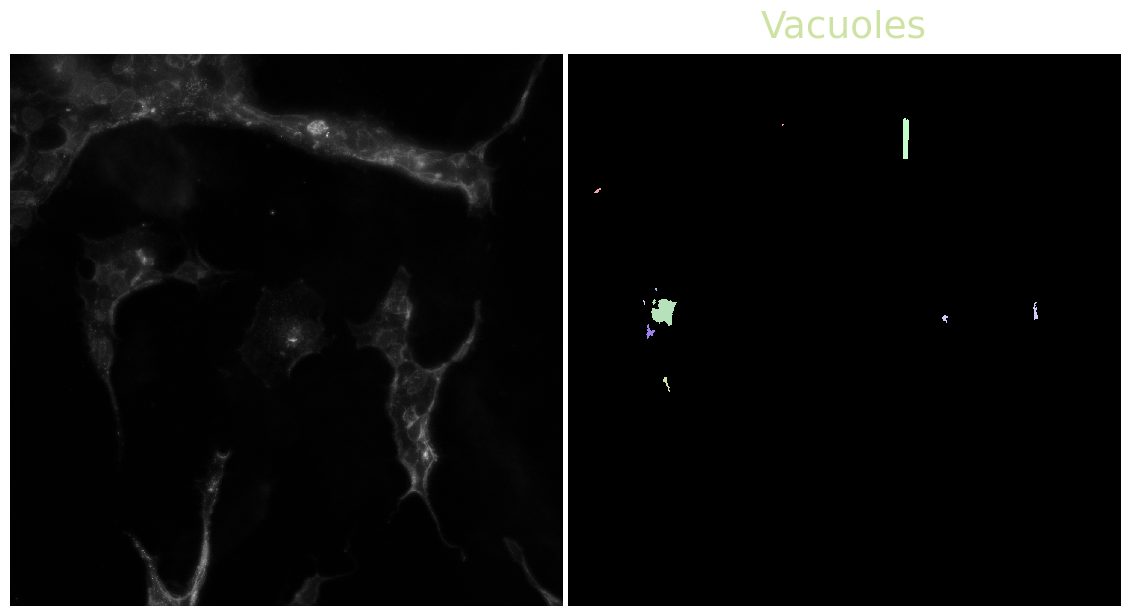

Enhanced visualization with cell boundaries, vacuole boundaries, and detected peaks:


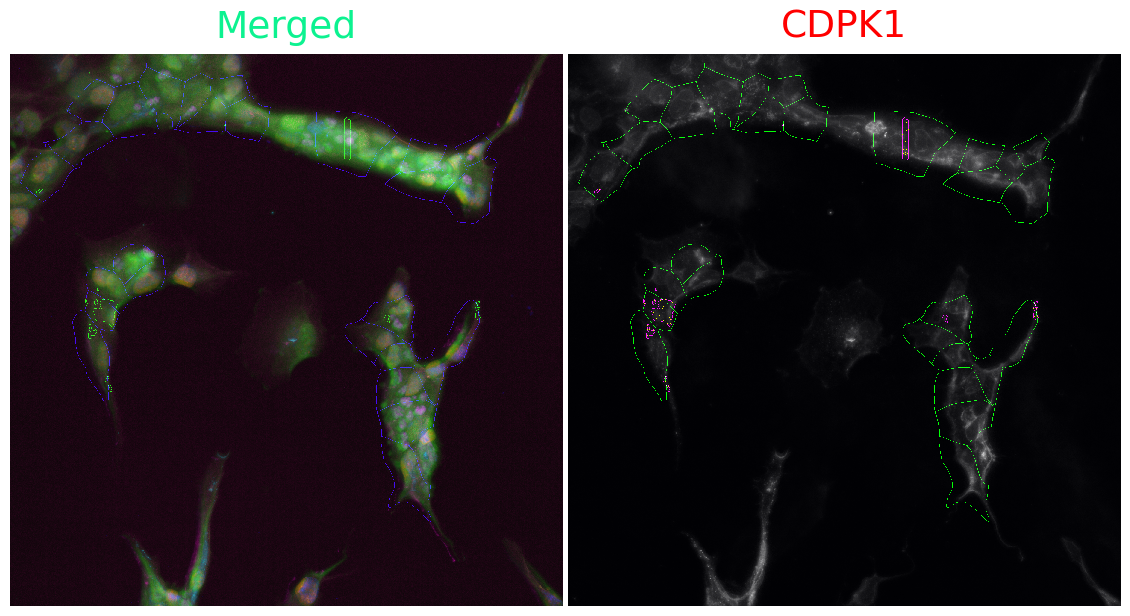

In [14]:
# Segment vacuoles if enabled
if VACUOLE_DETECTION:
    print(f"Performing vacuole segmentation with {VACUOLE_CHANNEL}...")
    
    vacuole_masks, cell_vacuole_table, updated_cytoplasm_masks = segment_vacuoles(
        image=corrected_image,
        vacuole_channel_index=VACUOLE_CHANNEL_INDEX,
        nuclei_channel_index=VACUOLE_CHANNEL_INDEX, 
        cell_masks=cells,
        cytoplasm_masks=cytoplasms,
        min_size=VACUOLE_MIN_SIZE,
        max_size=VACUOLE_MAX_SIZE,
        nuclei_min_distance=5,
        nuclei_centroids=phenotype_minimal
    )
    cell_summary = cell_vacuole_table['cell_summary']
    vacuole_cell_mapping = cell_vacuole_table['vacuole_cell_mapping']
    
    # Print statistics
    print(f"Found vacuoles in {cell_summary['has_vacuole'].sum()} out of {len(cell_summary)} cells")
    print(f"Average vacuoles per cell with vacuoles: {cell_summary.loc[cell_summary['has_vacuole'], 'num_vacuoles'].mean():.2f}")
    print(f"Average vacuole area ratio: {cell_summary['vacuole_area_ratio'].mean():.4f}")
    print(f"Total nuclei detected within vacuoles: {cell_summary['total_nuclei_in_vacuoles'].sum()}")
    print(f"Number of multinucleated vacuoles: {cell_summary['multinucleated_vacuole_count'].sum()}")
    
    # Create standard visualizations
    print("Example microplots for vacuole channel and vacuole segmentation:")
    vacuole_cmap = random_cmap(num_colors=len(np.unique(vacuole_masks)))
    vacuole_microimages = [
        Microimage(
            corrected_image[VACUOLE_CHANNEL_INDEX],
            channel_names=VACUOLE_CHANNEL,
            cmaps="gray",
        ),
        Microimage(vacuole_masks, cmaps=vacuole_cmap, channel_names="Vacuoles"),
    ]
    vacuole_panel = create_micropanel(vacuole_microimages, add_channel_label=True)
    plt.show()
    
    # Create enhanced boundary visualization with peaks
    print("Enhanced visualization with cell boundaries, vacuole boundaries, and detected peaks:")
    boundary_panel = create_vacuole_boundary_visualization(
        corrected_image,
        VACUOLE_CHANNEL_INDEX,
        cell_masks=cells,
        vacuole_masks=vacuole_masks,
        vacuole_cell_mapping=vacuole_cell_mapping,
        channel_names=CHANNEL_NAMES,
        show_nuclei_peaks=True
    )
    plt.show()

In [15]:
# Extract the two DataFrames from the dictionary
cell_summary_df = cell_vacuole_table['cell_summary']
vacuole_cell_mapping_df = cell_vacuole_table['vacuole_cell_mapping']

# Display the cell summary DataFrame
print("Cell Summary DataFrame:")
display(cell_summary_df)

# Display the vacuole-cell mapping DataFrame
print("\nVacuole-Cell Mapping DataFrame:")
display(vacuole_cell_mapping_df)

Cell Summary DataFrame:


cell_id  has_vacuole  num_vacuoles   vacuole_ids  cell_area  \
0         1        False             0            []      30384   
1         2        False             0            []      18697   
2         3        False             0            []      16717   
3         4        False             0            []      23599   
4         5        False             0            []      41192   
5         6         True             1          [12]      20326   
6         7        False             0            []      27893   
7         8         True             1          [10]      70934   
8         9        False             0            []      31166   
9        10        False             0            []      13001   
10       11        False             0            []      19350   
11       12         True             1          [14]      31787   
12       13        False             0            []      42091   
13       14        False             0            []      28510   
14       15        False             0            []      19457   
15       16        False             0            []      19835   
16       17         True             1          [22]      22150   
17       18         True             3  [24, 25, 26]      16185   
18       19         True             1          [28]      27241   
19       20         True             1          [27]      30321   
20       21         True             2      [30, 34]      35980   
21       22        False             0            []      25088   
22       23        False             0            []      15857   
23       24        False             0            []      17080   
24       25        False             0            []      30406   
25       26        False             0            []      35284   
26       27        False             0            []      41690   

    total_vacuole_area  vacuole_area_ratio  total_nuclei_in_vacuoles  \
0                    0            0.000000                         0   
1                    0            0.000000                         0   
2                    0            0.000000                         0   
3                    0            0.000000                         0   
4                    0            0.000000                         0   
5                   51            0.002509                         1   
6                    0            0.000000                         0   
7                 4472            0.063045                        23   
8                    0            0.000000                         0   
9                    0            0.000000                         0   
10                   0            0.000000                         0   
11                 278            0.008746                         3   
12                   0            0.000000                         0   
13                   0            0.000000                         0   
14                   0            0.000000                         0   
15                   0            0.000000                         0   
16                  78            0.003521                         2   
17                8322            0.514180                        37   
18                 529            0.019419                         5   
19                 914            0.030144                         7   
20                1716            0.047693                        15   
21                   0            0.000000                         0   
22                   0            0.000000                         0   
23                   0            0.000000                         0   
24                   0            0.000000                         0   
25                   0            0.000000                         0   
26                   0            0.000000                         0   

    multinucleated_vacuole_count  mean_distance_to_nucleus  
0                              0                 


Vacuole-Cell Mapping DataFrame:


vacuole_id  cell_id  vacuole_area  overlap_ratio  nuclei_count  \
0           10        8          4472       1.000000            23   
1           12        6            51       0.901961             1   
2           14       12           278       1.000000             3   
3           22       17            78       1.000000             2   
4           24       18          7956       0.865385            33   
5           25       18           241       1.000000             2   
6           26       18           125       0.688000             2   
7           27       20           914       0.733042             7   
8           28       19           529       1.000000             5   
9           30       21          1068       1.000000             8   
10          34       21           648       0.364198             7   

                                     peak_coordinates  distance_to_nucleus  \
0   [[437, 1474], [430, 1463], [406, 1458], [437, ...            84.357855   
1                                        [[311, 933]]            82.694476   
2                [[599, 129], [591, 136], [605, 117]]            89.947352   
3                          [[1024, 381], [1033, 381]]            55.383403   
4   [[1122, 434], [1090, 447], [1131, 442], [1082,...            13.411003   
5                          [[1083, 373], [1074, 376]]            67.654438   
6                          [[1088, 331], [1076, 330]]            97.487018   
7   [[1085, 2027], [1139, 2030], [1143, 2037], [11...           213.834528   
8   [[1156, 1635], [1145, 1632], [1147, 1645], [11...            59.295426   
9   [[1205, 372], [1182, 345], [1200, 353], [1233,...            96.104291   
10  [[1462, 435], [1423, 413], [1416, 425], [1426,...           119.741839   

    nearest_nucleus_id  
0                    7  
1                    5  
2                   11  
3                   16  
4                   17  
5                   17  
6                   17  
7                   19  
8                   18  
9                   17  
10                  20

In [16]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    aligned_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

Extracting phenotype features:


label  nucleus_DAPI_int  nucleus_ConA_int  nucleus_Mitotracker_int  \
0       1           1437112           1541416                  1554971   
1       2            977989           1074168                  1549705   
2       3           3356689           2065106                  2322632   
3       4           5429384           1660580                  1536738   
4       5           2696657           2075586                  2786946   
5       6           2775873           1774836                  1949288   
6       7           2956171           3113361                  2757698   
7       8           6314021           7948133                  6861013   
8       9           2732007           1391524                   976809   
9      10           2787482           1130462                   588215   
10     11           3211714           4363263                  2627054   
11     12           5350765           2929895                  1498998   
12     13           4816579           4824335                  2202715   
13     14           3528333           5021570                  3832266   
14     15           1324237            914594                  3310494   
15     16           3498845           1636827                  2692296   
16     17           2973495           1479296                  2531457   
17     18           1888674           1036345                  1570578   
18     19           2005630           1902826                  1035722   
19     20           2016958           2019116                  1500766   
20     21           1864292           1101680                   862429   
21     22           1763437           1262509                   900615   
22     23           1627070           1092612                  1172010   
23     24           1977942           1593771                  1305245   
24     25           2538538           2689976                  2760984   
25     26           2654245           3061925                  4639765   
26     27           3089258           2517386                  2145881   

    nucleus_Stat6_int  nucleus_NHS_ester_int  nucleus_Tubulin_int  \
0             2500583               24093203              3715200   
1             2679144               23758761              3635415   
2             4154437               42585487              4888980   
3             3372691               33155360              5960977   
4             3928935               36402765              3860329   
5             4230613               37450711              4729591   
6             5093392               48048090              7508733   
7            11071458              105055297             12581603   
8             2373791               18573653              3370230   
9             2012940               15031181              2414827   
10            5835396               54283706              6274288   
11            4985381               35530980              6484557   
12            6129038               46419318              4586644   
13            6229187               58253011              5589023   
14            3581813               28305440              4085664   
15            4144138               41227031              3910501   
16            4729069               43572963              3912986   
17            2689430               23702088              4856850   
18            3187823               23740230              4680833   
19            3240814               21583798              2485203   
20            2842929               17895124              3968840   
21            2466032               17979177              3385715   
22            3145653               23675347              3746507   
23            2828727               22774783              4214057   
24            3760218               30779232              5539025   
25            5578409               44948388              7350437   
26            4932807               30101275              4000556   

In [17]:
# Extract phenotype features for vacuoles
vacuole_phenotype = extract_phenotype_vacuoles(
    aligned_image,
    vacuoles=vacuole_masks,
    vacuole_cell_mapping_df=cell_vacuole_table['vacuole_cell_mapping'],
    wildcards=WILDCARDS,
    foci_channel=FOCI_CHANNEL, 
    channel_names=CHANNEL_NAMES
)

In [18]:
vacuole_phenotype

vacuole_id  cell_id  vacuole_area_x  overlap_ratio  nuclei_count  \
0           10        8            4472       1.000000            23   
1           12        6              51       0.901961             1   
2           14       12             278       1.000000             3   
3           22       17              78       1.000000             2   
4           24       18            7956       0.865385            33   
5           25       18             241       1.000000             2   
6           26       18             125       0.688000             2   
7           27       20             914       0.733042             7   
8           28       19             529       1.000000             5   
9           30       21            1068       1.000000             8   
10          34       21             648       0.364198             7   

                                     peak_coordinates  distance_to_nucleus  \
0   [[437, 1474], [430, 1463], [406, 1458], [437, ...            84.357855   
1                                        [[311, 933]]            82.694476   
2                [[599, 129], [591, 136], [605, 117]]            89.947352   
3                          [[1024, 381], [1033, 381]]            55.383403   
4   [[1122, 434], [1090, 447], [1131, 442], [1082,...            13.411003   
5                          [[1083, 373], [1074, 376]]            67.654438   
6                          [[1088, 331], [1076, 330]]            97.487018   
7   [[1085, 2027], [1139, 2030], [1143, 2037], [11...           213.834528   
8   [[1156, 1635], [1145, 1632], [1147, 1645], [11...            59.295426   
9   [[1205, 372], [1182, 345], [1200, 353], [1233,...            96.104291   
10  [[1462, 435], [1423, 413], [1416, 425], [1426,...           119.741839   

    nearest_nucleus_id  vacuole_DAPI_int  vacuole_ConA_int  ...  \
0                    7            639707           2263977  ...   
1                    5              5153             11945  ...   
2                   11             32144             72461  ...   
3                   16             13331             15247  ...   
4                   17           1853301           1634383  ...   
5                   17             29289             65602  ...   
6                   17              9687             20252  ...   
7                   19             62344            165780  ...   
8                   18             74647            141047  ...   
9                   17             82332            204233  ...   
10                  20             47989             99913  ...   

    vacuole_bounds_1  vacuole_bounds_2  vacuole_bounds_3  tile  well  \
0               1452               462              1478     1    A3   
1                928               316               936     1    A3   
2                115               608               144     1    A3   
3                379              1036               386     1    A3   
4                361              1187               473     1    A3   
5                366              1092               381     1    A3   
6                327              1096               336     1    A3   
7               2019              1159              2041     1    A3   
8               1623              1176              1649     1    A3   
9                340              1241               377     1    A3   
10               412              1470               442     1    A3   

    vacuole_number_neighbors_1  vacuole_percent_touching_1  \
0                            0                         0.0   
1                            0                         0.0   
2                            0                         0.0   
3                            0                         0.0   
4                            0                         0.0   
5                            0                         0.0   
6                            0                         0.0   
7                            0      

In [19]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',
 'cell_j',
 'cell_lower_quartile',
 'c

## Add phenotype process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [ ]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "segmentation_method": SEGMENTATION_METHOD,
    "segment_cells": SEGMENT_CELLS,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "mode": None,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "flow_threshold": FLOW_THRESHOLD,
        "cellprob_threshold": CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["phenotype"].update({
        "microsam_model": MICROSAM_MODEL,
        "points_per_side": POINTS_PER_SIDE,
        "points_per_batch": POINTS_PER_BATCH,
        "stability_score_thresh": STABILITY_SCORE_THRESH,
        "pred_iou_thresh": PRED_IOU_THRESH,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update({
        "stardist_model": STARDIST_MODEL,
        "prob_thresh": PROB_THRESH,
        "nms_thresh": NMS_THRESH,
    })

if ALIGN:
    config["phenotype"]["alignments"] = ALIGNMENTS

if VACUOLE_DETECTION:
    config["phenotype"].update({
        "vacuole_detection": VACUOLE_DETECTION,
        "vacuole_channel_index": VACUOLE_CHANNEL_INDEX,
        "vacuole_min_size": VACUOLE_MIN_SIZE,
        "vacuole_max_size": VACUOLE_MAX_SIZE,
    })

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)